In [1]:
!pip install duckdb  --pre --upgrade

Create Parquet folder and Json folder to hold Query profile results

In [2]:
import os
directory = "./json"
if not os.path.exists(directory):
    os.makedirs(directory)
import os
directory = "./parquet"
if not os.path.exists(directory):
    os.makedirs(directory)
sf = 1

Generate TPCH Parquet files

In [3]:
%%time
import duckdb

con = duckdb.connect()
con.execute("set temp_directory='./'")
con.execute(f"CALL dbgen(sf={sf});")
def generate_parquet_delta(table):
    xxx = con.execute(f"select * from {table}").fetch_arrow_table(100000)
    result = con.execute(f"COPY (select * from xxx) to './parquet/{table}.parquet' (FORMAT 'PARQUET', CODEC 'ZSTD')")
for x in ['lineitem','nation','region','customer','supplier','orders','partsupp','part'] :
   generate_parquet_delta(x)
con.close()

CPU times: total: 54 s
Wall time: 51.3 s


Load Parquet files to DuckDB storage file

In [4]:
%%time
import duckdb 
con = duckdb.connect(database='tpch.duckdb')

df=con.execute(f'''
create or replace table  partsupp  as select *  FROM './parquet/partsupp.parquet';
create or replace table part  as select * FROM './parquet/part.parquet' order by P_NAME;
create or replace table supplier  as select * FROM './parquet/supplier.parquet' ;
create or replace table nation  as select * FROM './parquet/nation.parquet';
create or replace table region  as select * FROM './parquet/region.parquet' ;
create or replace table lineitem   as select * FROM './parquet/lineitem.parquet' order by L_SHIPDATE;
create or replace table orders   as select * FROM './parquet/orders.parquet' ;
create or replace table customer   as select * FROM './parquet/customer.parquet'
''')
con.close()

CPU times: total: 59.4 s
Wall time: 28.5 s


**Run TPCH Test**

In [5]:
%%time
import duckdb

con = duckdb.connect(database='tpch.duckdb',read_only=True)
con.execute("PRAGMA enable_object_cache")

con.execute('''
PRAGMA enable_profiling='json';
PRAGMA profile_output='./json/1.json';
SELECT
    --Query01
    l_returnflag,
    l_linestatus,
    SUM(l_quantity) AS sum_qty,
    SUM(l_extendedprice) AS sum_base_price,
    SUM(l_extendedprice * (1 - l_discount)) AS sum_disc_price,
    SUM(l_extendedprice * (1 - l_discount) * (1 + l_tax)) AS sum_charge,
    AVG(l_quantity) AS avg_qty,
    AVG(l_extendedprice) AS avg_price,
    AVG(l_discount) AS avg_disc,
    COUNT(*) AS count_order
FROM
    lineitem
WHERE
    l_shipdate <= CAST('1998-09-02' AS date)
GROUP BY
    l_returnflag,
    l_linestatus
ORDER BY
    l_returnflag,
    l_linestatus;


    


PRAGMA profile_output='./json/2.json';


SELECT
    --Query02
    s_acctbal,
    s_name,
    n_name,
    p_partkey,
    p_mfgr,
    s_address,
    s_phone,
    s_comment
FROM
    part,
    supplier,
    partsupp,
    nation,
    region
WHERE
    p_partkey = ps_partkey
    AND s_suppkey = ps_suppkey
    AND p_size = 15
    AND p_type LIKE '%BRASS'
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'EUROPE'
    AND ps_supplycost = (
        SELECT
            MIN(ps_supplycost)
        FROM
            partsupp,
            supplier,
            nation,
            region
        WHERE
            p_partkey = ps_partkey
            AND s_suppkey = ps_suppkey
            AND s_nationkey = n_nationkey
            AND n_regionkey = r_regionkey
            AND r_name = 'EUROPE'
    )
ORDER BY
    s_acctbal DESC,
    n_name,
    s_name,
    p_partkey
LIMIT
    100;




PRAGMA profile_output='./json/3.json';


SELECT
    --Query03
    l_orderkey,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    o_orderdate,
    o_shippriority
FROM
    customer,
    orders,
    lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < CAST('1995-03-15' AS date)
    AND l_shipdate > CAST('1995-03-15' AS date)
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue DESC,
    o_orderdate
LIMIT
    10;


    


PRAGMA profile_output='./json/4.json';


SELECT
    --Query04
    o_orderpriority,
    COUNT(*) AS order_count
FROM
    orders
WHERE
    o_orderdate >= CAST('1993-07-01' AS date)
    AND o_orderdate < CAST('1993-10-01' AS date)
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem
        WHERE
            l_orderkey = o_orderkey
            AND l_commitdate < l_receiptdate
    )
GROUP BY
    o_orderpriority
ORDER BY
    o_orderpriority;


    


PRAGMA profile_output='./json/5.json';


SELECT
    --Query05
    n_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    customer,
    orders,
    lineitem,
    supplier,
    nation,
    region
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND l_suppkey = s_suppkey
    AND c_nationkey = s_nationkey
    AND s_nationkey = n_nationkey
    AND n_regionkey = r_regionkey
    AND r_name = 'ASIA'
    AND o_orderdate >= CAST('1994-01-01' AS date)
    AND o_orderdate < CAST('1995-01-01' AS date)
GROUP BY
    n_name
ORDER BY
    revenue DESC;


    

PRAGMA profile_output='./json/6.json';


SELECT
    --Query06
    SUM(l_extendedprice * l_discount) AS revenue
FROM
    lineitem
WHERE
    l_shipdate >= CAST('1994-01-01' AS date)
    AND l_shipdate < CAST('1995-01-01' AS date)
    AND l_discount BETWEEN 0.05
    AND 0.07
    AND l_quantity < 24;


    

PRAGMA profile_output='./json/7.json';


SELECT
    --Query07
    supp_nation,
    cust_nation,
    l_year,
    SUM(volume) AS revenue
FROM
    (
        SELECT
            n1.n_name AS supp_nation,
            n2.n_name AS cust_nation,
            EXTRACT(
                year
                FROM
                    l_shipdate
            ) AS l_year,
            l_extendedprice * (1 - l_discount) AS volume
        FROM
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2
        WHERE
            s_suppkey = l_suppkey
            AND o_orderkey = l_orderkey
            AND c_custkey = o_custkey
            AND s_nationkey = n1.n_nationkey
            AND c_nationkey = n2.n_nationkey
            AND (
                (
                    n1.n_name = 'FRANCE'
                    AND n2.n_name = 'GERMANY'
                )
                OR (
                    n1.n_name = 'GERMANY'
                    AND n2.n_name = 'FRANCE'
                )
            )
            AND l_shipdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
    ) AS shipping
GROUP BY
    supp_nation,
    cust_nation,
    l_year
ORDER BY
    supp_nation,
    cust_nation,
    l_year;


    

PRAGMA profile_output='./json/8.json';


SELECT
    --Query08
    o_year,
    SUM(
        CASE
            WHEN nation = 'BRAZIL' THEN volume
            ELSE 0
        END
    ) / SUM(volume) AS mkt_share
FROM
    (
        SELECT
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) AS volume,
            n2.n_name AS nation
        FROM
            part,
            supplier,
            lineitem,
            orders,
            customer,
            nation n1,
            nation n2,
            region
        WHERE
            p_partkey = l_partkey
            AND s_suppkey = l_suppkey
            AND l_orderkey = o_orderkey
            AND o_custkey = c_custkey
            AND c_nationkey = n1.n_nationkey
            AND n1.n_regionkey = r_regionkey
            AND r_name = 'AMERICA'
            AND s_nationkey = n2.n_nationkey
            AND o_orderdate BETWEEN CAST('1995-01-01' AS date)
            AND CAST('1996-12-31' AS date)
            AND p_type = 'ECONOMY ANODIZED STEEL'
    ) AS all_nations
GROUP BY
    o_year
ORDER BY
    o_year;


    


PRAGMA profile_output='./json/9.json';




SELECT
    --Query09
    nation,
    o_year,
    SUM(amount) AS sum_profit
FROM
    (
        SELECT
            n_name AS nation,
            EXTRACT(
                year
                FROM
                    o_orderdate
            ) AS o_year,
            l_extendedprice * (1 - l_discount) - ps_supplycost * l_quantity AS amount
        FROM
            part,
            supplier,
            lineitem,
            partsupp,
            orders,
            nation
        WHERE
            s_suppkey = l_suppkey
            AND ps_suppkey = l_suppkey
            AND ps_partkey = l_partkey
            AND p_partkey = l_partkey
            AND o_orderkey = l_orderkey
            AND s_nationkey = n_nationkey
            AND p_name LIKE '%green%'
    ) AS profit
GROUP BY
    nation,
    o_year
ORDER BY
    nation,
    o_year DESC;


    


PRAGMA profile_output='./json/10.json';


SELECT
    --Query10
    c_custkey,
    c_name,
    SUM(l_extendedprice * (1 - l_discount)) AS revenue,
    c_acctbal,
    n_name,
    c_address,
    c_phone,
    c_comment
FROM
    customer,
    orders,
    lineitem,
    nation
WHERE
    c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate >= CAST('1993-10-01' AS date)
    AND o_orderdate < CAST('1994-01-01' AS date)
    AND l_returnflag = 'R'
    AND c_nationkey = n_nationkey
GROUP BY
    c_custkey,
    c_name,
    c_acctbal,
    c_phone,
    n_name,
    c_address,
    c_comment
ORDER BY
    revenue DESC
LIMIT
    20;




PRAGMA profile_output='./json/11.json';


SELECT
    --Query11
    ps_partkey,
    SUM(ps_supplycost * ps_availqty) AS value
FROM
    partsupp,
    supplier,
    nation
WHERE
    ps_suppkey = s_suppkey
    AND s_nationkey = n_nationkey
    AND n_name = 'GERMANY'
GROUP BY
    ps_partkey
HAVING
    SUM(ps_supplycost * ps_availqty) > (
        SELECT
            SUM(ps_supplycost * ps_availqty) * 0.0001
            -- SUM(ps_supplycost * ps_availqty) * 1
        FROM
            partsupp,
            supplier,
            nation
        WHERE
            ps_suppkey = s_suppkey
            AND s_nationkey = n_nationkey
            AND n_name = 'GERMANY'
    )
ORDER BY
    value DESC;


    


PRAGMA profile_output='./json/12.json';


SELECT
    --Query12
    l_shipmode,
    SUM(
        CASE
            WHEN o_orderpriority = '1-URGENT'
            OR o_orderpriority = '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS high_line_count,
    SUM(
        CASE
            WHEN o_orderpriority <> '1-URGENT'
            AND o_orderpriority <> '2-HIGH' THEN 1
            ELSE 0
        END
    ) AS low_line_count
FROM
    orders,
    lineitem
WHERE
    o_orderkey = l_orderkey
    AND l_shipmode IN ('MAIL', 'SHIP')
    AND l_commitdate < l_receiptdate
    AND l_shipdate < l_commitdate
    AND l_receiptdate >= CAST('1994-01-01' AS date)
    AND l_receiptdate < CAST('1995-01-01' AS date)
GROUP BY
    l_shipmode
ORDER BY
    l_shipmode;


    


PRAGMA profile_output='./json/13.json';


SELECT
    --Query13
    c_count,
    COUNT(*) AS custdist
FROM
    (
        SELECT
            c_custkey,
            COUNT(o_orderkey) AS c_count
        FROM
            customer
            LEFT OUTER JOIN orders ON c_custkey = o_custkey
            AND o_comment NOT LIKE '%special%requests%'
        GROUP BY
            c_custkey
    ) AS c_orders
GROUP BY
    c_count
ORDER BY
    custdist DESC,
    c_count DESC;


    


PRAGMA profile_output='./json/14.json';


SELECT
    --Query14
    100.00 * SUM(
        CASE
            WHEN p_type LIKE 'PROMO%' THEN l_extendedprice * (1 - l_discount)
            ELSE 0
        END
    ) / SUM(l_extendedprice * (1 - l_discount)) AS promo_revenue
FROM
    lineitem,
    part
WHERE
    l_partkey = p_partkey
    AND l_shipdate >= date '1995-09-01'
    AND l_shipdate < CAST('1995-10-01' AS date);


    


PRAGMA profile_output='./json/15.json';


SELECT
    --Query15
    s_suppkey,
    s_name,
    s_address,
    s_phone,
    total_revenue
FROM
    supplier,
    (
        SELECT
            l_suppkey AS supplier_no,
            SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
        FROM
            lineitem
        WHERE
            l_shipdate >= CAST('1996-01-01' AS date)
            AND l_shipdate < CAST('1996-04-01' AS date)
        GROUP BY
            supplier_no
    ) revenue0
WHERE
    s_suppkey = supplier_no
    AND total_revenue = (
        SELECT
            MAX(total_revenue)
        FROM
            (
                SELECT
                    l_suppkey AS supplier_no,
                    SUM(l_extendedprice * (1 - l_discount)) AS total_revenue
                FROM
                    lineitem
                WHERE
                    l_shipdate >= CAST('1996-01-01' AS date)
                    AND l_shipdate < CAST('1996-04-01' AS date)
                GROUP BY
                    supplier_no
            ) revenue1
    )
ORDER BY
    s_suppkey;


    


PRAGMA profile_output='./json/16.json';


SELECT
    --Query16
    p_brand,
    p_type,
    p_size,
    COUNT(DISTINCT ps_suppkey) AS supplier_cnt
FROM
    partsupp,
    part
WHERE
    p_partkey = ps_partkey
    AND p_brand <> 'Brand#45'
    AND p_type NOT LIKE 'MEDIUM POLISHED%'
    AND p_size IN (
        49,
        14,
        23,
        45,
        19,
        3,
        36,
        9
    )
    AND ps_suppkey NOT IN (
        SELECT
            s_suppkey
        FROM
            supplier
        WHERE
            s_comment LIKE '%Customer%Complaints%'
    )
GROUP BY
    p_brand,
    p_type,
    p_size
ORDER BY
    supplier_cnt DESC,
    p_brand,
    p_type,
    p_size;


    


PRAGMA profile_output='./json/17.json';


SELECT
    --Query17
    SUM(l_extendedprice) / 7.0 AS avg_yearly
FROM
    lineitem,
    part
WHERE
    p_partkey = l_partkey
    AND p_brand = 'Brand#23'
    AND p_container = 'MED BOX'
    AND l_quantity < (
        SELECT
            0.2 * AVG(l_quantity)
        FROM
            lineitem
        WHERE
            l_partkey = p_partkey
    );
    


PRAGMA profile_output='./json/18.json';


SELECT
    --Query18
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice,
    SUM(l_quantity)
FROM
    customer,
    orders,
    lineitem
WHERE
    o_orderkey IN (
        SELECT
            l_orderkey
        FROM
            lineitem
        GROUP BY
            l_orderkey
        HAVING
            SUM(l_quantity) > 300
    )
    AND c_custkey = o_custkey
    AND o_orderkey = l_orderkey
GROUP BY
    c_name,
    c_custkey,
    o_orderkey,
    o_orderdate,
    o_totalprice
ORDER BY
    o_totalprice DESC,
    o_orderdate
LIMIT
    100;
    

PRAGMA profile_output='./json/19.json';


SELECT
    --Query19
    SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
    lineitem,
    part
WHERE
    (
        p_partkey = l_partkey
        AND p_brand = 'Brand#12'
        AND p_container IN (
            'SM CASE',
            'SM BOX',
            'SM PACK',
            'SM PKG'
        )
        AND l_quantity >= 1
        AND l_quantity <= 1 + 10
        AND p_size BETWEEN 1
        AND 5
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#23'
        AND p_container IN (
            'MED BAG',
            'MED BOX',
            'MED PKG',
            'MED PACK'
        )
        AND l_quantity >= 10
        AND l_quantity <= 10 + 10
        AND p_size BETWEEN 1
        AND 10
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    )
    OR (
        p_partkey = l_partkey
        AND p_brand = 'Brand#34'
        AND p_container IN (
            'LG CASE',
            'LG BOX',
            'LG PACK',
            'LG PKG'
        )
        AND l_quantity >= 20
        AND l_quantity <= 20 + 10
        AND p_size BETWEEN 1
        AND 15
        AND l_shipmode IN ('AIR', 'AIR REG')
        AND l_shipinstruct = 'DELIVER IN PERSON'
    );
    


PRAGMA profile_output='./json/20.json';


SELECT
    --Query20
    s_name,
    s_address
FROM
    supplier,
    nation
WHERE
    s_suppkey IN (
        SELECT
            ps_suppkey
        FROM
            partsupp
        WHERE
            ps_partkey IN (
                SELECT
                    p_partkey
                FROM
                    part
                WHERE
                    p_name LIKE 'forest%'
            )
            AND ps_availqty > (
                SELECT
                    0.5 * SUM(l_quantity)
                FROM
                    lineitem
                WHERE
                    l_partkey = ps_partkey
                    AND l_suppkey = ps_suppkey
                    AND l_shipdate >= CAST('1994-01-01' AS date)
                    AND l_shipdate < CAST('1995-01-01' AS date)
            )
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'CANADA'
ORDER BY
    s_name;
    


PRAGMA profile_output='./json/21.json';


SELECT
    --Query21
    s_name,
    COUNT(*) AS numwait
FROM
    supplier,
    lineitem l1,
    orders,
    nation
WHERE
    s_suppkey = l1.l_suppkey
    AND o_orderkey = l1.l_orderkey
    AND o_orderstatus = 'F'
    AND l1.l_receiptdate > l1.l_commitdate
    AND EXISTS (
        SELECT
            *
        FROM
            lineitem l2
        WHERE
            l2.l_orderkey = l1.l_orderkey
            AND l2.l_suppkey <> l1.l_suppkey
    )
    AND NOT EXISTS (
        SELECT
            *
        FROM
            lineitem l3
        WHERE
            l3.l_orderkey = l1.l_orderkey
            AND l3.l_suppkey <> l1.l_suppkey
            AND l3.l_receiptdate > l3.l_commitdate
    )
    AND s_nationkey = n_nationkey
    AND n_name = 'SAUDI ARABIA'
GROUP BY
    s_name
ORDER BY
    numwait DESC,
    s_name
LIMIT
    100;
    


PRAGMA profile_output='./json/22.json';


SELECT
    --Query22
    cntrycode,
    COUNT(*) AS numcust,
    SUM(c_acctbal) AS totacctbal
FROM
    (
        SELECT
            SUBSTRING(c_phone, 1, 2) AS cntrycode,
            c_acctbal
        FROM
            customer
        WHERE
            SUBSTRING(c_phone, 1, 2) IN (
                '13',
                '31',
                '23',
                '29',
                '30',
                '18',
                '17'
            )
            AND c_acctbal > (
                SELECT
                    AVG(c_acctbal)
                FROM
                    customer
                WHERE
                    c_acctbal > 0.00
                    AND SUBSTRING(c_phone, 1, 2) IN (
                        '13',
                        '31',
                        '23',
                        '29',
                        '30',
                        '18',
                        '17'
                    )
            )
            AND NOT EXISTS (
                SELECT
                    *
                FROM
                    orders
                WHERE
                    o_custkey = c_custkey
            )
    ) AS custsale
GROUP BY
    cntrycode
ORDER BY
    cntrycode;
    
''')
con.close()

CPU times: total: 25.5 s
Wall time: 7.05 s


In [4]:
import duckdb 
con = duckdb.connect()
raw=con.execute('''SELECT *  FROM read_csv_auto('./json/*.json',FILENAME=True) ;''').df()
raw=con.execute('''SELECT filename, first(column0) as dur  FROM raw where column0 like '%"timing"%' group by 1;''').df()
raw.head(2)

,filename,dur
0,.\json\1.json,"""timing"": 0.277197,"
1,.\json\10.json,"""timing"": 0.336357,"


In [5]:
df=con.execute('''select replace(filename,'.\json','') as Query, replace(dur,'"timing":','') as dur from raw     ''').df()
df=con.execute('''select replace(Query,'\\','') as Query, replace(dur,',','') as dur from df     ''').df()
df=con.execute('''select replace(Query,'.json','') as Query,  dur from df     ''').df()
df=con.execute('''select cast (Query as integer) as Query,  cast( dur as numeric) as dur from df order by Query    ''').df()
df

,Query,dur
0,1,0.277
1,2,0.085
2,3,0.163
3,4,0.309
4,5,0.199
5,6,0.018
6,7,0.337
7,8,0.126
8,9,0.367
9,10,0.336


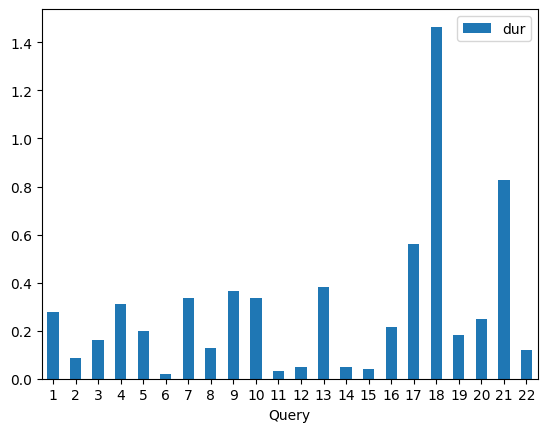

In [6]:
ax = df.plot.bar(x='Query', y='dur', rot=0)